In [1]:
import logging
from sentinelhub import DataCollection
from sentinelhub import SHConfig
from sentinel_api import sentinel_single_image, sentinel_territory
import numpy as np
from PIL import Image
import os

### Logging in sentinel account

In [2]:
logging.basicConfig(level=logging.INFO)

# Your client credentials
client_id = '4cd57ae1-fca5-418a-8404-91a7ead5fd29'
client_secret = 'ZorwJrsHHYOATSNAIRTMvq241c4TIj04ElFfoRQV'

config = SHConfig(instance_id='',
         sh_client_id = client_id,
         sh_client_secret = client_secret,
         sh_base_url='https://services.sentinel-hub.com',
         sh_token_url='https://services.sentinel-hub.com/oauth/token',)

In [3]:
evalscript = """
            //VERSION=3

            function setup() {
                return {
                    input: [{
                        bands: ["B02", "B03", "B04"]
                    }],
                    output: {
                        bands: 3
                    },
                };
            }

            function evaluatePixel(sample) {
                return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];

            }
        """

In [ ]:
evalscript = """
            //VERSION=3
            let minVal = 0.0;
            let maxVal = 0.4;

            let viz = new HighlightCompressVisualizer(minVal, maxVal);

            function setup() {
            return {
                input: ["B04", "B03", "B02","dataMask"],
                output: { bands: 4 }
            };
            }

            function evaluatePixel(samples) {
                let val = [samples.B04, samples.B03, samples.B02,samples.dataMask];
                return viz.processList(val);
            }
"""


### Download an image from Sentinel-hub API (fn: sentinel_single_image)

Territory dimensions: 10,186m x 11,119m | Area: 113 km^2
Requesting images with 10m resolution and region size of (2500, 2500) pixels


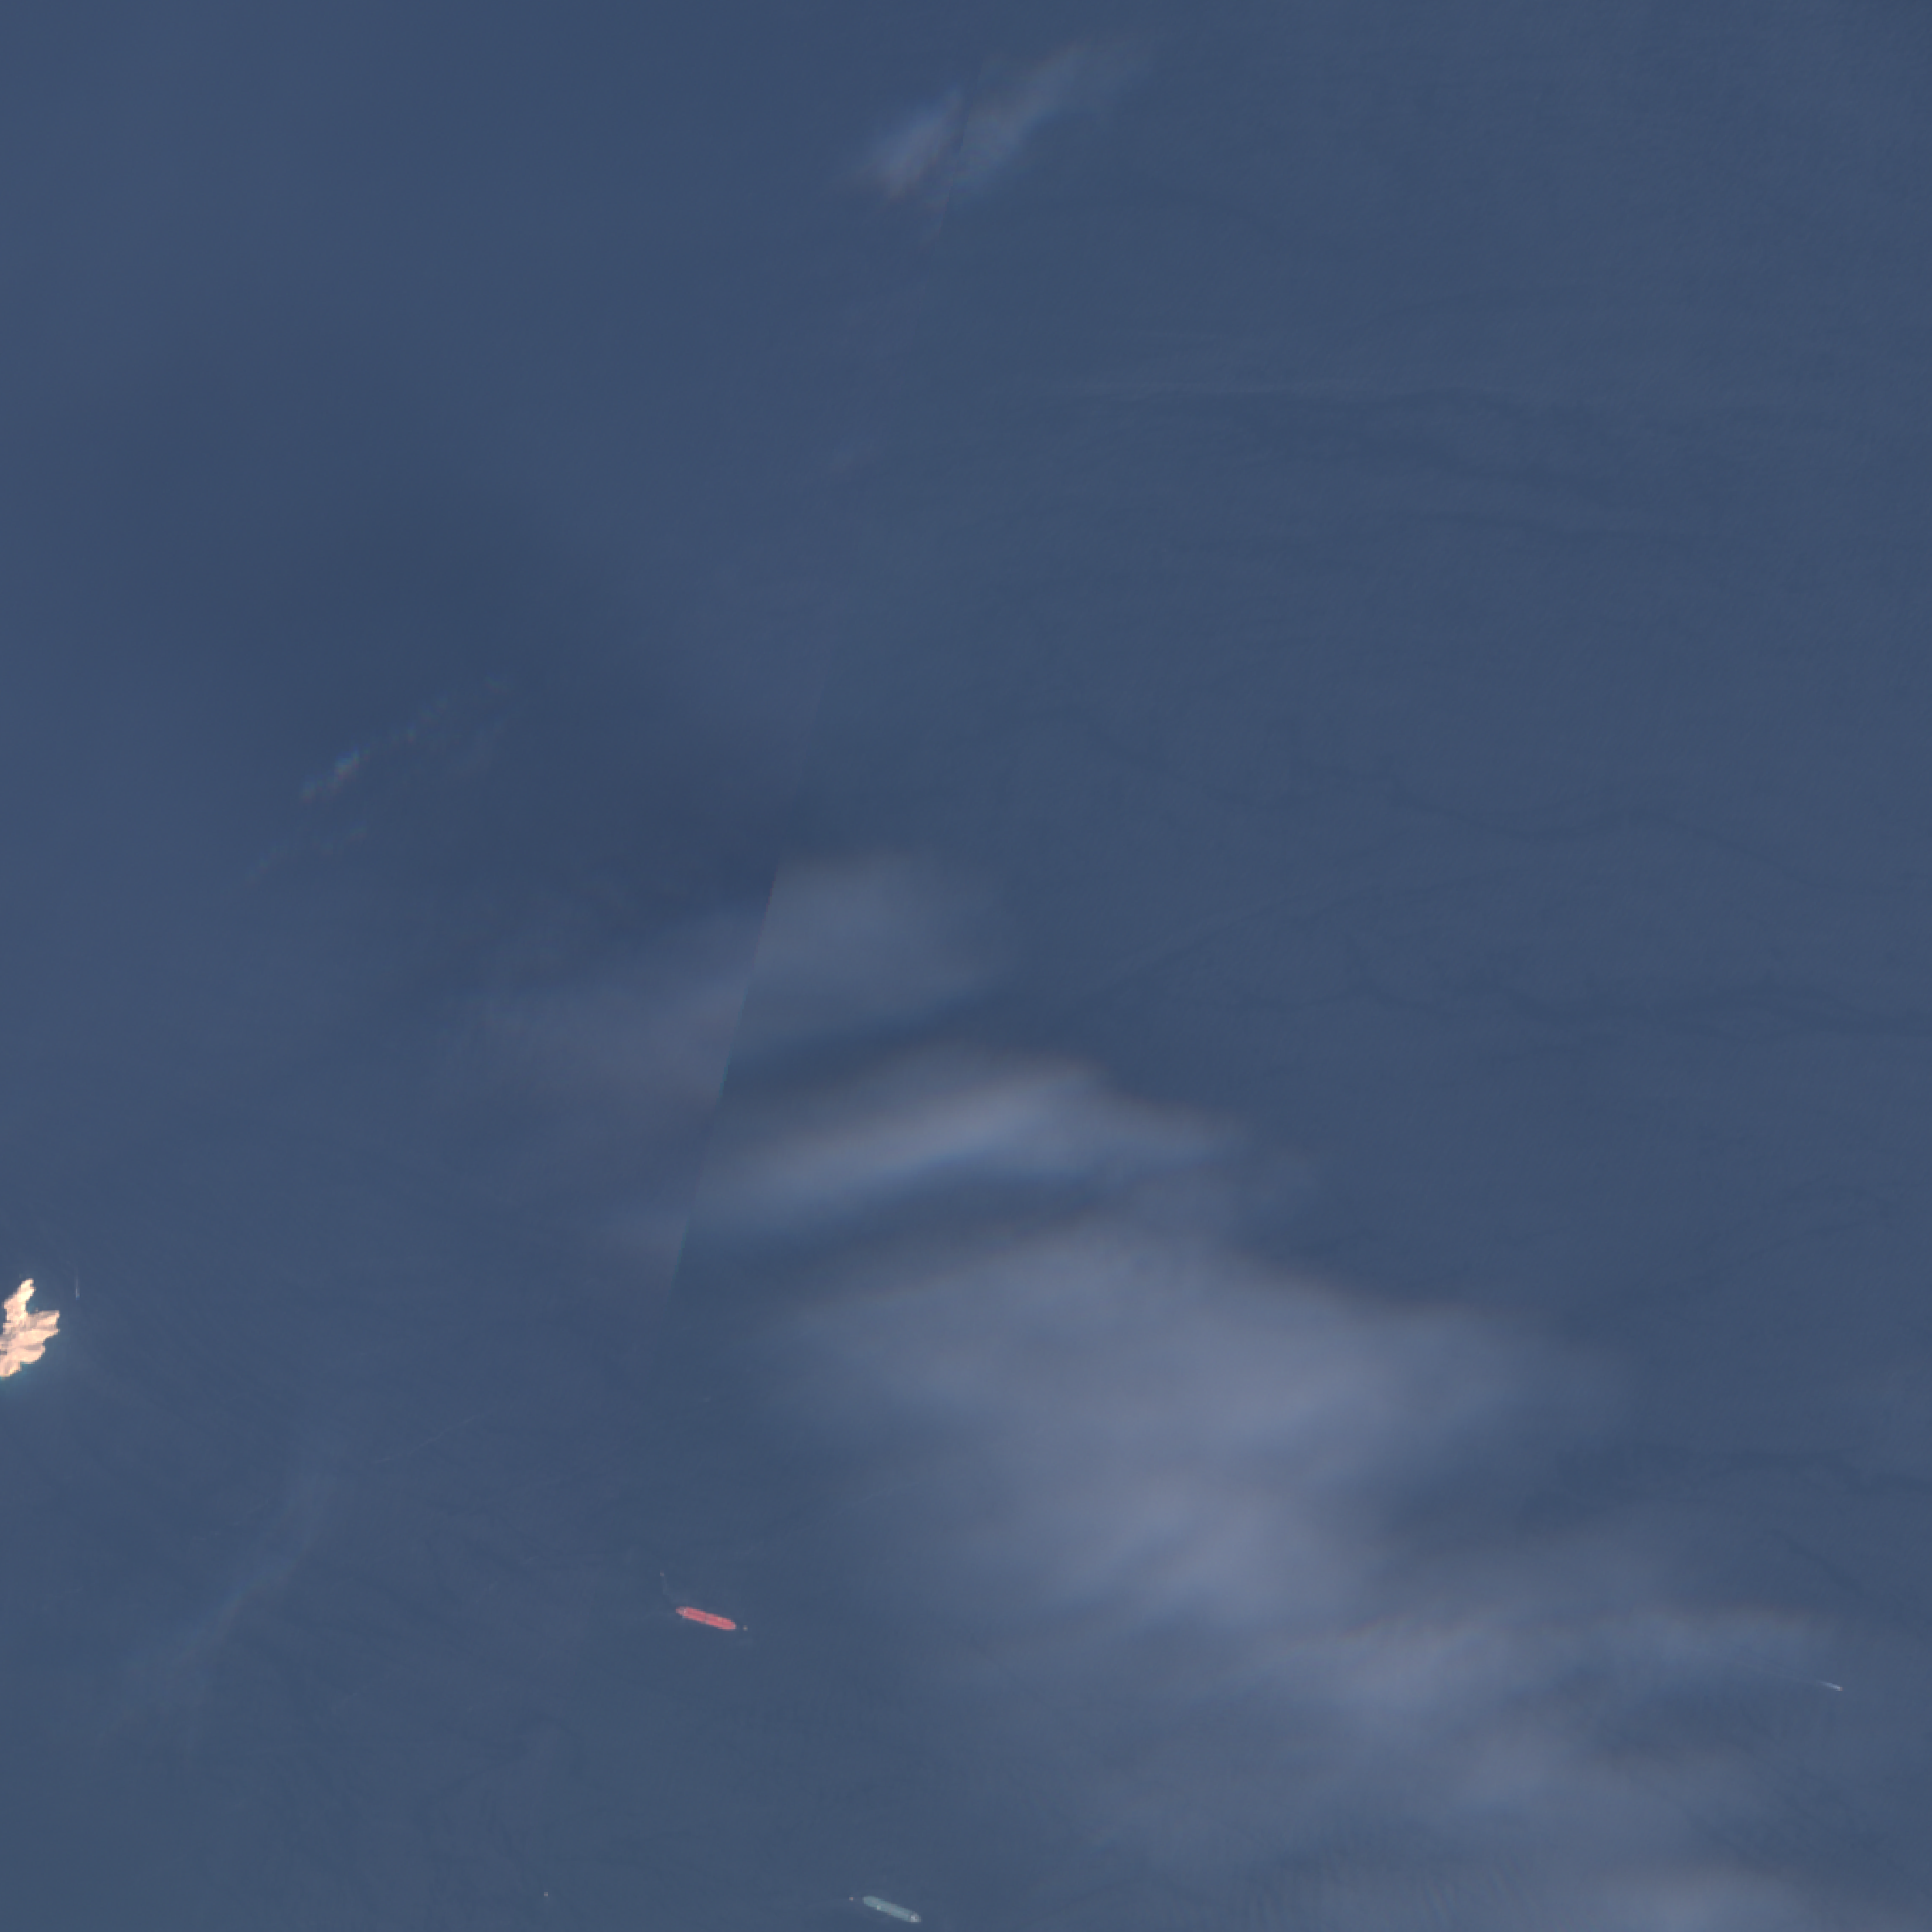

In [6]:
# fn input
bbox = [58.50, 23.65, 58.60, 23.75]
timeline = ('2023-07-05', '2023-09-25')

# Parameters
mosaicking_order_modes = ['mostRecent', 'leastCC', 'leastRecent']
data_collection_modes = [DataCollection.SENTINEL2_L2A, DataCollection.SENTINEL2_L1C]

img = sentinel_single_image(bbox, timeline, config=config, data_collection=data_collection_modes[1], mosaicking_order = mosaicking_order_modes[0],evalscript=evalscript,
                            resolution=10, maxcc=0.8, img_size=(2500,2500), return_numpy=False, verbose=True, save_image=False, save_dir="sentinel-hub")
img.save(r"C:\Users\user2\Desktop\sentinel-3.png")
img

### Download images of a vast area from Sentinel-hub API (fn: sentinel_territory)

#### In disk

In [10]:
# fn inputs:
# bbox_coords = [58.5, 23.6, 59, 24.1]
# bbox_coords = [58.5, 23.6, 58.8, 23.9]
bbox_coords = [55.0 , 24.97, 55.1, 25.02]
# bbox_coords = [55.0 , 25.12, 55.15, 25.27]
timeline = ('2023-10-10', '2023-10-28')

# Parameters
mosaicking_order_modes = ['mostRecent', 'leastCC', 'leastRecent']
data_collection_modes = [DataCollection.SENTINEL2_L2A, DataCollection.SENTINEL2_L1C]

final_image = sentinel_territory(bbox_coords, timeline, config, lon_lat_step=(0.01, 0.01), data_collection=data_collection_modes[0], mosaicking_order = 'mostRecent', maxcc=0.8,
                                resolution=10, img_size=(256, 256), save_concat_image=True, in_memory=False, temp_dir=r"sentinel-tmp",evalscript=evalscript,
                                concat_image_dir=r"sentinel-concat", concat_image_name="default", delete_temp=False, ignore_inference_size_error=True)

Territory dimensions: 10,080m x 5,560m | Area: 56 km^2
Concatenated image will be in size of 2560 x 1280 p (if all of its area is supported by sentinel-hub)
There are 66 bboxes to download



dl from sentinel-hub | bbox: [55.1, 25.02, 55.11, 25.03]: 100%|████████████████████████| 66/66 [01:18<00:00,  1.01s/it]

All images are downloaded into disk - concatenating images is in progress...


dl from sentinel-hub | bbox: [55.1, 25.02, 55.11, 25.03]: 100%|████████████████████████| 66/66 [01:19<00:00,  1.20s/it]

Done!
concatenated image saved in sentinel-concat


#### In memory

In [ ]:
# fn inputs
bbox_coords = [58.7, 23.6, 58.9, 23.8]
timeline = ('2023-07-05', '2023-09-25')

# Parameters
mosaicking_order_modes = ['mostRecent', 'leastCC', 'leastRecent']
data_collection_modes = [DataCollection.SENTINEL2_L2A, DataCollection.SENTINEL2_L1C]

concat_image = sentinel_territory(bbox_coords, timeline, config, data_collection=data_collection_modes[1], mosaicking_order = 'mostRecent', maxcc=0.8,evalscript=evalscript,
                      resolution=5, img_size=(2500,2500), lon_lat_step=(0.05, 0.05), in_memory=True, save_concat_image=True, evalscript=evalscript ,
                      concat_image_dir=r"sentinel-concat", concat_image_name="default", delete_temp=False)

### Integrated Inference (sentinel and inference modules integration)

In [ ]:
print(type(concat_image))
print(concat_image.size)

In [ ]:
from inference_modular import ship_detection
from PIL import Image
# images_path = r"D:\NLP 1\Sat_object_detection\inference_images"
# images_path = r"D:\NLP 1\Sat_object_detection\debug_images_2\e7e24507a.jpg"
# images_path = r"D:\NLP 1\Sat_object_detection\sentinel-concat\2023-07-05_2023-09-25-[58.5, 23.6, 58.7, 23.8]-res5-(2500, 2500)-mostRecent-sentinel-2-l1c-maxcc0.8.jpg"
# images_path = r"D:\NLP 1\Sat_object_detection\sentinel-concat\2023-07-05_2023-09-25-[58.7, 23.6, 58.9, 23.8]-res5-(2500, 2500)-mostRecent-sentinel-2-l1c-maxcc0.8.jpg"
images_path = r"D:\NLP 1\Sat_object_detection\sentinel-concat\2023-07-05_2023-09-25-[58.5, 23.6, 58.7, 23.8]-res5-(2500, 2500)-mostRecent-sentinel-2-l1c-maxcc0.8.jpg"
img = Image.open(images_path)
bbox_coords = [58.7, 23.6, 58.9, 23.8]

result_pred = ship_detection(images=img, bbox_coord_wgs84=bbox_coords, annotations=["score", "length", "coord"], nms_iou_threshold=0.15, scale_down_factor= 3,
                        adaptive_scale_down_parameters = {'a': 0.3, 'b': 1, 'threshold': 1.5}, confidence_threshold=0.85, sahi_overlap_ratio=0.05,
                        output_annotated_image=True, save_annotated_image=True, output_original_image=True
                        , output_dir=r"D:\NLP 1\Sat_object_detection\sentinel-concat-annotations", 
                        # output_name="prediction", annotation_font_size=12, annotation_font=r"calibri.ttf", annotation_bbox_width=1,
                        )


In [ ]:
result_pred[]

In [ ]:
result_pred["annotated_image"]

In [ ]:
# result_pred["original_image"]
result_pred["annotated_image"]

In [ ]:
from PIL import Image
images_path = r"D:\NLP 1\Sat_object_detection\sentinel-concat\2023-07-05_2023-09-25-[58.5, 23.6, 59, 24.1]-res5-(2500, 2500)-mostRecent-sentinel-2-l1c-maxcc0.8.jpg"
img = Image.open(images_path)

### Drafts